In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error
import pandas as pd

## LSTM model 得到残差

156
mean: 4937.389166666667 std: 10090.160996755762
154
len train_x: 120
len test_x 34
epoch:790, train_loss:0.004765638615936041, test_loss:7.067440492392052e-06
len value: 156
len prediction: 154


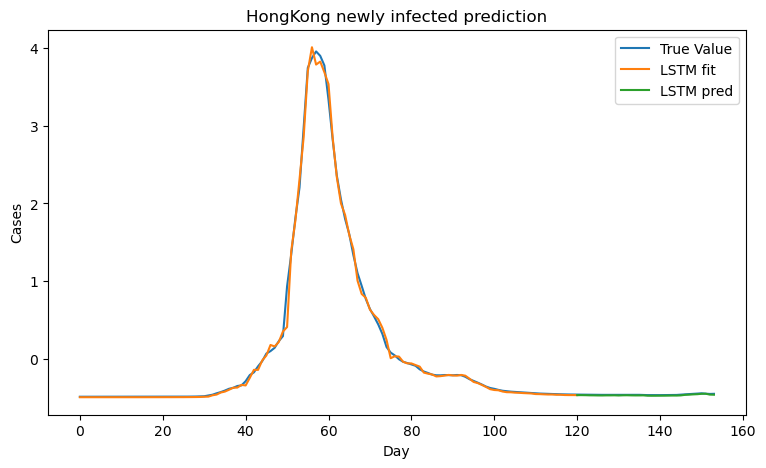

MSE: 5782.184631347881
MAE: 67.73541934742646
MAD: 68.15376953124996


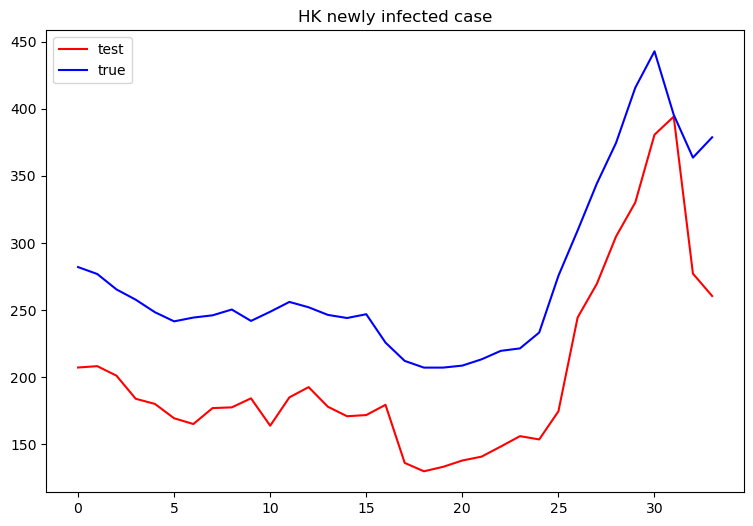

In [52]:

import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# 数据预处理
import pandas as pd
df = pd.read_excel('hk5thProcessed.xlsx')    # 这个会直接默认读取到这个Excel的第一个表单
value = df['avgInfected'].values[:]
#value = df['全国累计确诊'].values[10:50]
print(len(value))  # 162


# data scaling
mean = np.mean(value, axis=0)  # 均值
v = np.std(value, axis=0) # 方差
value = (value - mean) / v #得到归一化结果
print("mean:",mean, "std:", v)
x = []
y = []
seq = 2
for i in range(len(value)-seq):
    x.append(value[i:i+seq])
    y.append(value[i+seq])
print(len(x))   # 159
train_x = (torch.tensor(x[:120]).float()).reshape(-1, seq, 1)
train_y = (torch.tensor(y[:120]).float()).reshape(-1, 1)
test_x = (torch.tensor(x[120:]).float()).reshape(-1, seq, 1)
test_y = (torch.tensor(y[120:]).float()).reshape(-1, 1)

print('len train_x:',len(train_x))
print('len test_x',len(test_x))

# 模型训练
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, num_layers=1, batch_first=True)
        self.linear = nn.Linear(32 * seq, 1)
    def forward(self, x):
        x, (h, c) = self.lstm(x)
        x = x.reshape(-1, 32 * seq)
        x = self.linear(x)
        return x

# 模型训练
model = LSTM()
optimzer = torch.optim.Adam(model.parameters(), lr=0.008)
loss_func = nn.MSELoss()
model.train()

for epoch in range(1200):
    output = model(train_x)
    loss = loss_func(output, train_y)
    optimzer.zero_grad()
    loss.backward()
    optimzer.step()
    if epoch == 790:
        tess_loss = loss_func(model(test_x), test_y)
        print("epoch:{}, train_loss:{}, test_loss:{}".format(epoch, loss, tess_loss))
# 模型预测、画图
plt.figure(figsize = (9,5))
model.eval()
prediction = list((model(train_x).data.reshape(-1))) + list((model(test_x).data.reshape(-1)))
plt.plot(value[2:], label='True Value')
plt.plot(prediction[:121], label='LSTM fit')
plt.plot(np.arange(120, len(x), 1), prediction[120:len(x)], label='LSTM pred')
print('len value:', len(value[:]))
print('len prediction:', len(prediction))
plt.legend(loc='best')
plt.title('HongKong newly infected prediction')
plt.xlabel('Day')
plt.ylabel('Cases')
plt.show()

pre_train = model(train_x).data.reshape(-1)
pre_test = model(test_x).data.reshape(-1)


pre_train = model(train_x).data.reshape(-1)
pre_test = model(test_x).data.reshape(-1)

pre_test_return = pre_test*v+mean
value_return = value*v+mean
pre_train_return = pre_train*v + mean

plt.figure(figsize=(9,6))
plt.plot(pre_test_return,c = 'r',label = "test")
len(pre_test)
len(value)
plt.plot(value_return[122:],c = 'b',label = "true")
plt.legend()
plt.title("HK newly infected case")
# print(value_return[120:])
# print(pre_test_return)
print("MSE:",mean_squared_error(pre_test_return,value_return[120:len(x)]))
print('MAE:',mean_absolute_error(pre_test_return,value_return[120:len(x)]))
print('MAD:',median_absolute_error(pre_test_return,value_return[120:len(x)]))

In [53]:
cancha = []
# pre_test_return = pre_test_return.tolist()
# pre_train_return  = pre_train_return.tolist()
pred_return = []
for i in range(len(pre_train_return)):
    pred_return.append(pre_train_return[i])

for i in range(len(pre_test_return)):
    pred_return.append(pre_test_return[i])
    
    
    
for i in range(154):
    tmp = pred_return[i] - value_return[i+2]
    cancha.append(tmp)

cancha = pd.DataFrame(cancha)
cancha.columns = ['resid']
cancha.to_csv('LSTM_first_resid.csv')

In [54]:
cancha

,resid
0,-63.771973
1,-63.941973
2,-63.617266
3,-63.775957
4,-63.775957
...,...
149,-85.615645
150,-62.252441
151,-1.424395
152,-86.560137


# ARIMA 做残差拟合

In [80]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
import itertools
import warnings
import csv


import seaborn as sns
from  statsmodels.tsa.arima_model  import  ARIMA
import statsmodels as sm
from scipy import stats 
resid=pd.read_csv('LSTM_first_resid.csv')

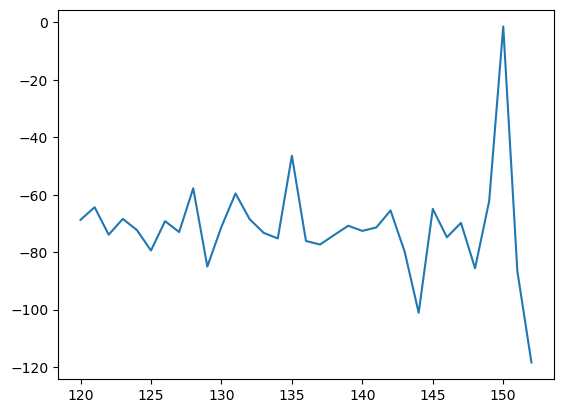

In [81]:
plt.plot(resid['resid'][120:])

In [82]:
resid["resid_diff_1"] = resid["resid"].diff(1)  #一阶差分
resid["resid_diff_2"] = resid["resid"].diff(2)  #二阶差分

In [83]:
#未差分平稳性检测（ADF检验、单位根检验）
from  statsmodels.tsa.stattools  import  adfuller  as  ADF
print(u'原始序列的ADF检验结果为：',  ADF(resid["resid"]))
#返回值依次为adf、pvalue、usedlag、nobs、critical  values、icbest、regresults、resstore  p<0.05时表示稳定

# p-value :2.643183344111615e-05 <0.05

from  statsmodels.tsa.stattools  import  adfuller  as  ADF
print(u'一阶差分序列的ADF检验结果为：',  ADF(resid["resid_diff_1"][1:]))
#返回值依次为adf、pvalue、usedlag、nobs、critical  values、icbest、regresults、resstore  p<0.05时表示稳定
# 一阶差分后，p value < 0.05，ARIMA中的参数d定为1

#信息准则定阶：AIC、BIC
import statsmodels.api as sm
def get_pq(data):
    #AIC
    AIC = sm.tsa.arma_order_select_ic(data, max_ar=6, max_ma=6, ic='aic')['aic_min_order']
    #BIC
    BIC = sm.tsa.arma_order_select_ic(data, max_ar=6, max_ma=6, ic='bic')['bic_min_order']
    print('the AIC is{},\nthe BIC is{}\n'.format(AIC,BIC))
get_pq(resid['resid'])

原始序列的ADF检验结果为： (-3.1004669756478793, 0.026518649491137063, 14, 138, {'1%': -3.47864788917503, '5%': -2.882721765644168, '10%': -2.578065326612056}, 2032.8916260237838)
一阶差分序列的ADF检验结果为： (-8.761862978020186, 2.6608141909370478e-14, 11, 140, {'1%': -3.4779446621720114, '5%': -2.8824156122448983, '10%': -2.577901887755102}, 2026.5731692716174)


H:\Anaconda3_2021\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
H:\Anaconda3_2021\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
H:\Anaconda3_2021\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
H:\Anaconda3_2021\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
H:\Anaconda3_2021\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarni

H:\Anaconda3_2021\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
H:\Anaconda3_2021\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
H:\Anaconda3_2021\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
H:\Anaconda3_2021\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
H:\Anaconda3_2021\anaconda\lib\site-packages\statsmodels\

the AIC is(2, 3),
the BIC is(0, 0)



H:\Anaconda3_2021\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [93]:
arima214 = sm.tsa.ARIMA(resid["resid"][120:],order=(4,0,3)).fit() #只跑预测部分的残差数据
arima214.summary()
df_pred = arima214.predict(1)
type(df_pred)
df_pred.to_csv('predict_LSTM_1.csv')
df_pred = pd.read_csv('predict_LSTM_1.csv')
df_pred.columns=['day','predict']
df_pred

,day,predict
0,121,-71.282849
1,122,-72.906706
2,123,-75.673287
3,124,-71.438650
4,125,-71.687987
5,126,-72.826531
6,127,-68.317442
7,128,-67.999063
8,129,-74.155298
9,130,-74.893318


In [86]:
cancha_2 = arima214.resid

In [87]:
stats.normaltest(cancha_2)#检验序列残差是否为正态分布    pvalue=0.00028625258929196876   <  0.05  拒绝原假设 认为残差符合正太分布

NormaltestResult(statistic=10.997727870022757, pvalue=0.0040914169146936165)

In [88]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(arima214.resid.values)     ##DW检验：靠近2——正常；靠近0——正自相关；靠近4——负自相关

1.977109436158801

<Figure size 2500x1500 with 0 Axes>

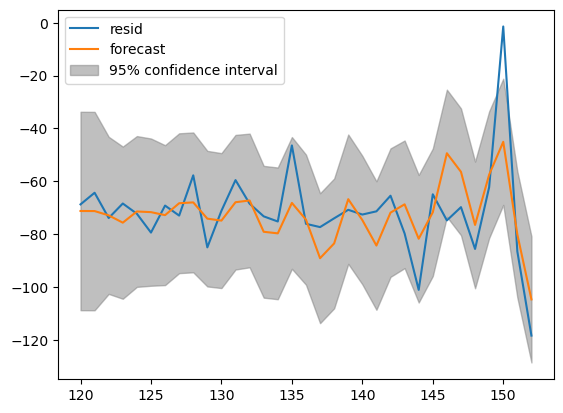

In [90]:
# 绘制原数据和预测数据对比图
from statsmodels.graphics.tsaplots import plot_predict
plt.figure(figsize=(25,15))
fig, ax = plt.subplots()
ax = resid['resid'].loc[120:].plot(ax=ax)
plot_predict(arima214,dynamic=False,ax=ax,plot_insample=False)

plt.legend()
plt.show()

In [105]:
result = []
for i in range (len(df_pred)):
    result.append(pre_test_return[i] - df_pred['predict'][i])

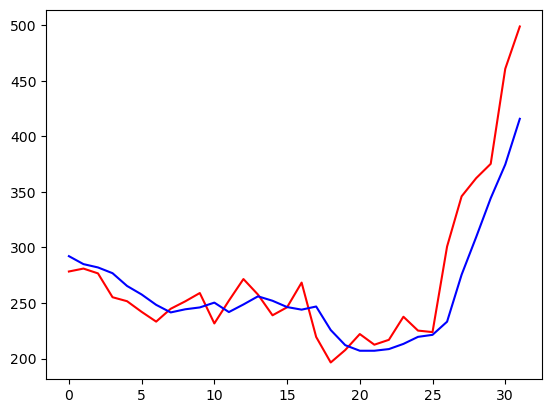

In [111]:
x=np.arange(32)
plt.plot(x,result,color = 'red')
plt.plot(x,df['avgInfected'][120:120+32] , color='blue')
plt.legend()
plt.grid(linestyle = '--')

In [112]:
#回归评价指标

from sklearn import metrics


MSE = metrics.mean_squared_error( df['avgInfected'][120:120+32], result)

RMSE = metrics.mean_squared_error( df['avgInfected'][120:120+32],result )**0.5

MAE = metrics.mean_absolute_error( df['avgInfected'][120:120+32], result)

MAPE = metrics.mean_absolute_percentage_error( df['avgInfected'][120:120+32],result)

print(MSE,',',RMSE,',',MAE,',',MAPE)

1049.8892110743495 , 32.40199393670626 , 22.42772720878763 , 0.08076492199737412
